In [1]:
import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import wbdata
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from descartes import PolygonPatch


In [2]:
#Importamos el dataset
gfi = pd.read_csv(r'C:\Users\wdi_w\Desktop\W\UTN\Poster\micro_world.csv') 

#Importamos las preguntas del cuestionario
quest = pd.read_csv(r'C:\Users\wdi_w\Desktop\W\UTN\Poster\Cuestionario.csv', delimiter=";")
questd= dict(zip(quest.id,quest.Variable)) #Convertimos el cuestionario en diccionario

#Importamos un mapamundi para utilizar con GeoPandas
mapamundi=gpd.GeoDataFrame.from_file(r'C:\Users\wdi_w\Desktop\W\UTN\Poster\World_Countries/World_Countries.shp')

#observamos el temaño de la base
print(f'Shape: {np.shape(gfi)}')


Shape: (154923, 105)


In [3]:
#Quitamos los duplicados
gfi.drop_duplicates(inplace=True, keep='first')
print(f'Shape: {np.shape(gfi)}')

Shape: (154923, 105)


In [4]:
gfi.head()

,economy,economycode,regionwb,pop_adult,wpid_random,wgt,female,age,educ,inc_q,...,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,pay_onlne,pay_onlne_mobintbuy,pay_cash,pay_cash_mobintbuy
0,Afghanistan,AFG,South Asia,19456060.0,139880545,1.936754,1,18.0,2.0,1,...,4,4,4,2.0,2,5.0,0.0,NaN,0.0,NaN
1,Afghanistan,AFG,South Asia,19456060.0,111705622,0.332867,2,25.0,1.0,5,...,4,4,4,4.0,4,5.0,0.0,NaN,0.0,NaN
2,Afghanistan,AFG,South Asia,19456060.0,128866217,1.338906,2,40.0,1.0,2,...,4,4,4,4.0,2,5.0,0.0,NaN,0.0,NaN
3,Afghanistan,AFG,South Asia,19456060.0,138171768,0.275619,2,45.0,1.0,1,...,4,4,4,4.0,4,5.0,0.0,NaN,0.0,NaN
4,Afghanistan,AFG,South Asia,19456060.0,125156190,0.629304,1,30.0,1.0,4,...,4,4,4,4.0,4,5.0,0.0,NaN,0.0,NaN


In [5]:
#Analizamos la cantidad de nulos
total = gfi.isnull().sum().sort_values(ascending=False)
porcentaje = (gfi.isnull().sum()/gfi.isnull().count()).sort_values(ascending=False)
data_faltante = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
data_faltante.head(30)

,Total,Porcentaje
fin45,153690,0.992041
fin41,152786,0.986206
fin44,151932,0.980694
fin40,150280,0.970030
fin47c5,148295,0.957217
fin47c3,148295,0.957217
fin47c4,148295,0.957217
fin27c1,146199,0.943688
fin27c2,146199,0.943688
fin47c1,145241,0.937504


In [6]:
gfif = gfi.drop((data_faltante[data_faltante['Porcentaje'] > 0.5]).index,1) # eliminamos las columnas con mas de 15% de Nulos


In [7]:
gfi_quest=gfif.iloc[:,11:] #Creamos un subset con los datos que tienen formato cuestionario
gfi_inx=gfif.iloc[:,0:1] #Creamos un subset con los paises 
gfi_inx2=gfif.iloc[:,2:3] #Creamos un subset con las regiones
gfi_datos=gfif.iloc[:,0:11] #Creamos un subset que incluye dichos indices y los datos que no son en formato cuestionario

paises=gfi['economy'].unique() # Tomamos los valores unicos de pais 
paises_c=gfi['economycode'].unique() #Hacemos lo mismo con el codigo de pais
region=gfi['regionwb'].unique() # Tomamos los valores unicos de region
gfi_pais=pd.DataFrame() #Creamos un DF vacio
gfi_region=pd.DataFrame() #Creamos un DF vacio

In [8]:
#Sobre el dataset que se le quitaron las columnas con mas de 50% de NaNs y luego filtrado a las respuestas en formato 
#cuestionario se le imputan los valores con un metodo multivariado,utilizando la estrategia de metodos mas frecuentes
imputer = IterativeImputer(missing_values = np.nan, initial_strategy = 'most_frequent', max_iter=3, random_state=0)
imputer = imputer.fit(gfi_quest)
gfi_quest2= (pd.DataFrame(imputer.transform(gfi_quest)))
gfi_quest2.columns=gfi_quest.columns
#se redondean las imputaciones para obtener valores enteros como son las respuestas del cuestionario
gfi_quest2=gfi_quest2.round(0)


In [9]:
gfi_p=gfi_inx.join([gfi_quest])
gfi_fr=gfi_inx2.join([gfi_quest]) #Incorporamos el indice a los datos del cuestionario
 

In [10]:
gfi_f2=gfi_datos.join(gfi_quest2)
gfif=gfi_f2.dropna() # eliminamos las filas nulas restantes
gfif.isnull().sum().max() #chequeamos que no haya otro valor nulo

0

In [11]:
#El nuevo tamaño del dataset
print(f'Shape: {np.shape(gfif)}')


Shape: (152466, 55)


In [12]:
#Para hacer un analisis por encuestado se mantiene del dataset limpado original, cada respuesta, 
#Nos quedamos solamente las respuestas positivas, en forma de 1 los si, y el resto de las respuestas en forma de 0
gfi_quest4=gfi_quest2.replace([2, 3, 4], 0)
gfi_f3=gfi_datos.join(gfi_quest4)
gfi_f3=gfi_f3.dropna()

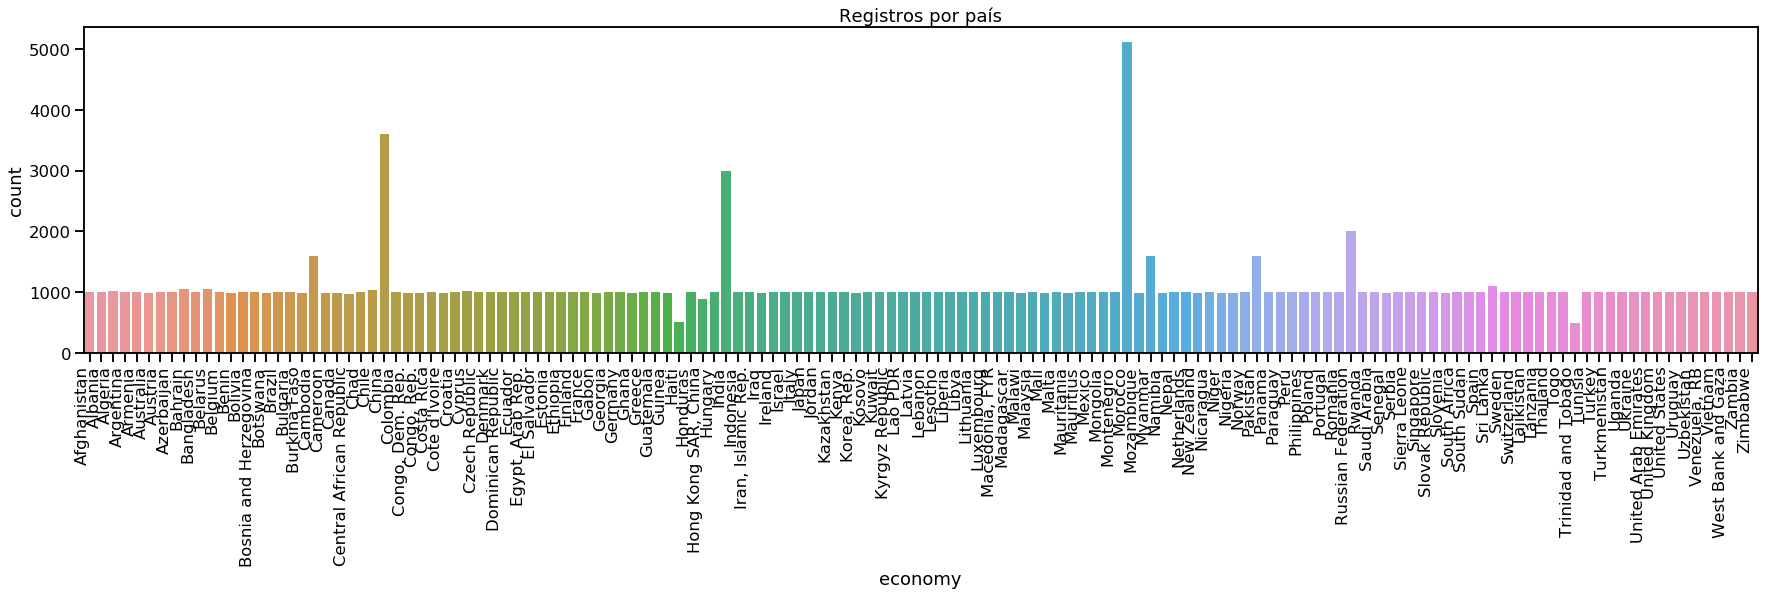

In [13]:
# graficamos la cantidad de observaciones por país 
sns.set_context("talk")
plt.figure(figsize=(30,6))
ax=sns.countplot(x="economy", data=gfif)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.title("Registros por país")
plt.show()

In [14]:
#generamos un loop que agrega al DF vacio una columna por cada pais, 
#y en los datos calcula el ratio entre las respuestas positivas (1) 
#sobre la suma entre positivas (1) y negativas (2)
#ignorando asi las respuestas con No se y No quiso contestar (3 y 4)

for x in paises: 
  gfi_pais[x]=(gfi_p[gfi_p.economy==x][gfi_quest2 ==1].count())/gfi_p[gfi_p.economy==x][gfi_quest2 <=2].count()
gfi_pais=gfi_pais.drop(['economy'])  #Eliminamos la fila pais que ahora sobra


In [15]:
#Hacemos lo mismo por region
for x in region: 
  gfi_region[x]=(gfi_fr[gfi_fr.regionwb==x][gfi_quest ==1].count())/gfi_fr[gfi_fr.regionwb==x][gfi_quest <=2].count()
gfi_region=gfi_region.drop(['regionwb'])  #Eliminamos la fila pais que ahora sobra

In [16]:
#Nos queda un dataset con el ratio de respuestas positivas para cada indicador para cada país
#Este dataset sera utilizado para hacer analisis por pais
gfi_pais.head()


,Afghanistan,Albania,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,"Venezuela, RB",Vietnam,West Bank and Gaza,Zambia,Zimbabwe
fin2,0.028169,0.279116,0.247247,0.465257,0.267748,0.908367,0.885542,0.347347,0.855660,0.069277,...,0.851446,0.934804,0.810811,0.544634,0.275827,0.685686,0.290486,0.189569,0.234818,0.249000
fin5,0.065359,0.102041,0.052516,0.210989,0.166667,0.651068,0.579832,0.115502,0.413214,0.166667,...,0.548122,0.523193,0.725926,0.259332,0.241758,0.403315,0.277027,0.098976,0.479730,0.501931
fin6,0.267974,0.150000,0.107692,0.220264,0.152542,0.663951,0.528917,0.196319,0.623740,0.127841,...,0.636898,0.680600,0.769799,0.312992,0.340659,0.534530,0.550336,0.253425,0.540541,0.650000
fin7,0.010081,0.072144,0.041965,0.268020,0.074490,0.684316,0.493976,0.077232,0.355724,0.003015,...,0.496503,0.691457,0.756757,0.401804,0.008016,0.281563,0.041068,0.040120,0.051935,0.019038
fin9,0.640523,0.647059,0.635575,0.690171,0.648649,0.948381,0.884178,0.802985,0.897380,0.527778,...,0.857809,0.946372,0.966387,0.750958,0.826241,0.874483,0.687500,0.671186,0.632716,0.711806


In [17]:
gfi_paist=gfi_pais.T #Transponemos el dataset por pais
gfi_dpais=gfi_datos.groupby(['economy', 'regionwb'], as_index=False).mean() #Agrupamos por promedios los datos que no estaban formato cuestionario
gfi_dpais=gfi_dpais.set_index('economy')
gfi_p2=gfi_dpais.join([gfi_paist] ) #Y lo unificamos con el del cuestionario por pais

In [18]:
gfi_regiont=gfi_region.T #Hacemos lo mismo por region
gfi_dregion=gfi_datos.groupby(['regionwb'], as_index=False).mean()
gfi_dregion=gfi_dregion.set_index('regionwb')
gfi_r2=gfi_dregion.join([gfi_regiont] )

In [19]:
gfi_p2.describe() #Vemos algunas estadisticas descriptivas

,pop_adult,wpid_random,wgt,female,age,educ,inc_q,emp_in,fin2,fin5,...,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,pay_onlne,pay_cash
count,1.430000e+02,1.430000e+02,1.430000e+02,143.000000,143.000000,143.000000,143.000000,142.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,108.000000,143.000000,109.000000,109.000000,109.000000
mean,3.734289e+07,1.598326e+08,1.000000e+00,1.536854,41.779826,1.862171,3.194140,0.634743,0.460833,0.318145,...,0.518628,0.484625,0.654261,0.726273,0.767691,0.258736,0.438695,0.665443,0.059174,0.046702
std,1.263540e+08,1.348767e+07,1.057338e-11,0.081585,7.000545,0.345860,0.091437,0.107944,0.310304,0.210014,...,0.168382,0.135505,0.251878,0.229212,0.216906,0.197417,0.306505,0.182305,0.093158,0.045607
min,3.739912e+05,1.366550e+04,1.000000e+00,1.264207,30.864048,1.182500,2.872071,0.378000,0.018260,0.023018,...,0.150000,0.209000,0.044146,0.094891,0.009434,0.008621,0.000000,0.182857,0.000000,0.000000
25%,4.041295e+06,1.603174e+08,1.000000e+00,1.501500,36.295722,1.620500,3.136500,0.576231,0.195789,0.144528,...,0.388000,0.393000,0.478760,0.587451,0.616440,0.113008,0.182565,0.555556,0.008000,0.016000
50%,8.408621e+06,1.610801e+08,1.000000e+00,1.543000,41.343000,1.858283,3.206349,0.645500,0.380762,0.273556,...,0.501000,0.467253,0.661972,0.776119,0.818182,0.212727,0.351562,0.659004,0.020000,0.031000
75%,2.479205e+07,1.614934e+08,1.000000e+00,1.596919,47.202635,2.159482,3.253000,0.704000,0.757432,0.461764,...,0.650000,0.563000,0.907158,0.926505,0.962795,0.356064,0.684996,0.795139,0.070000,0.057000
max,1.134634e+09,1.635656e+08,1.000000e+00,1.690000,60.059717,2.619143,3.418000,0.883350,0.987988,0.852525,...,0.900000,0.896311,1.000000,1.000000,1.000000,0.837209,0.996264,0.958525,0.437000,0.262000


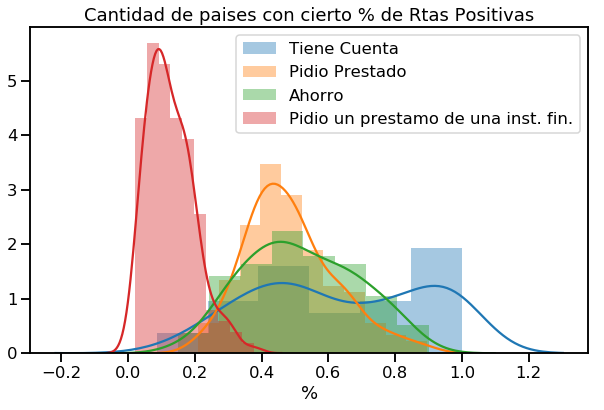

In [21]:
#Grafimos la distribución país del porctaje de respuestas positivas a sí -Tiene Cuenta -Pidió Prestado y -Ahorró
#Tambien incluimos la que sera nuestra varibale de interes: Si pidio prestado de una institución financiera
plt.figure(figsize=(10,6))
sns.distplot(gfi_p2['account'], label ='Tiene Cuenta')
sns.distplot(gfi_p2['borrowed'], label ='Pidio Prestado')
sns.distplot(gfi_p2['saved'], label ='Ahorro')
sns.distplot(gfi_p2['fin22a'], label ='Pidio un prestamo de una inst. fin.')
plt.title('Cantidad de paises con cierto % de Rtas Positivas')
plt.xlabel('%')
plt.legend(loc='upper right')
plt.show()

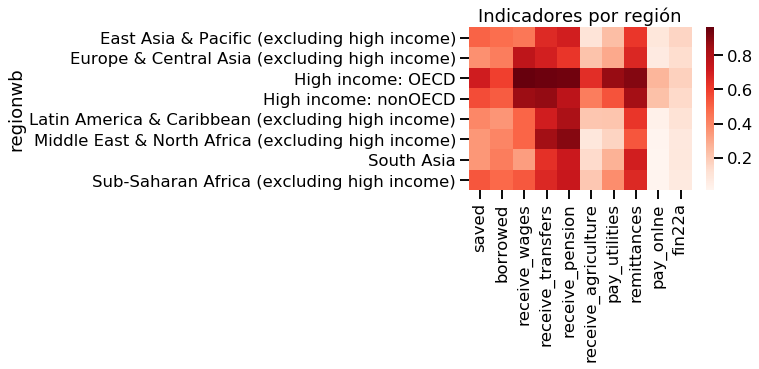

In [22]:
#Graficamos los indicadores por region
plt.figure(figsize=(5,3))
sns.heatmap(gfi_r2.iloc[:,-10:-1].join(gfi_r2[['fin22a']]),  cmap="Reds")
plt.title("Indicadores por región")
plt.show()

<Figure size 864x576 with 0 Axes>

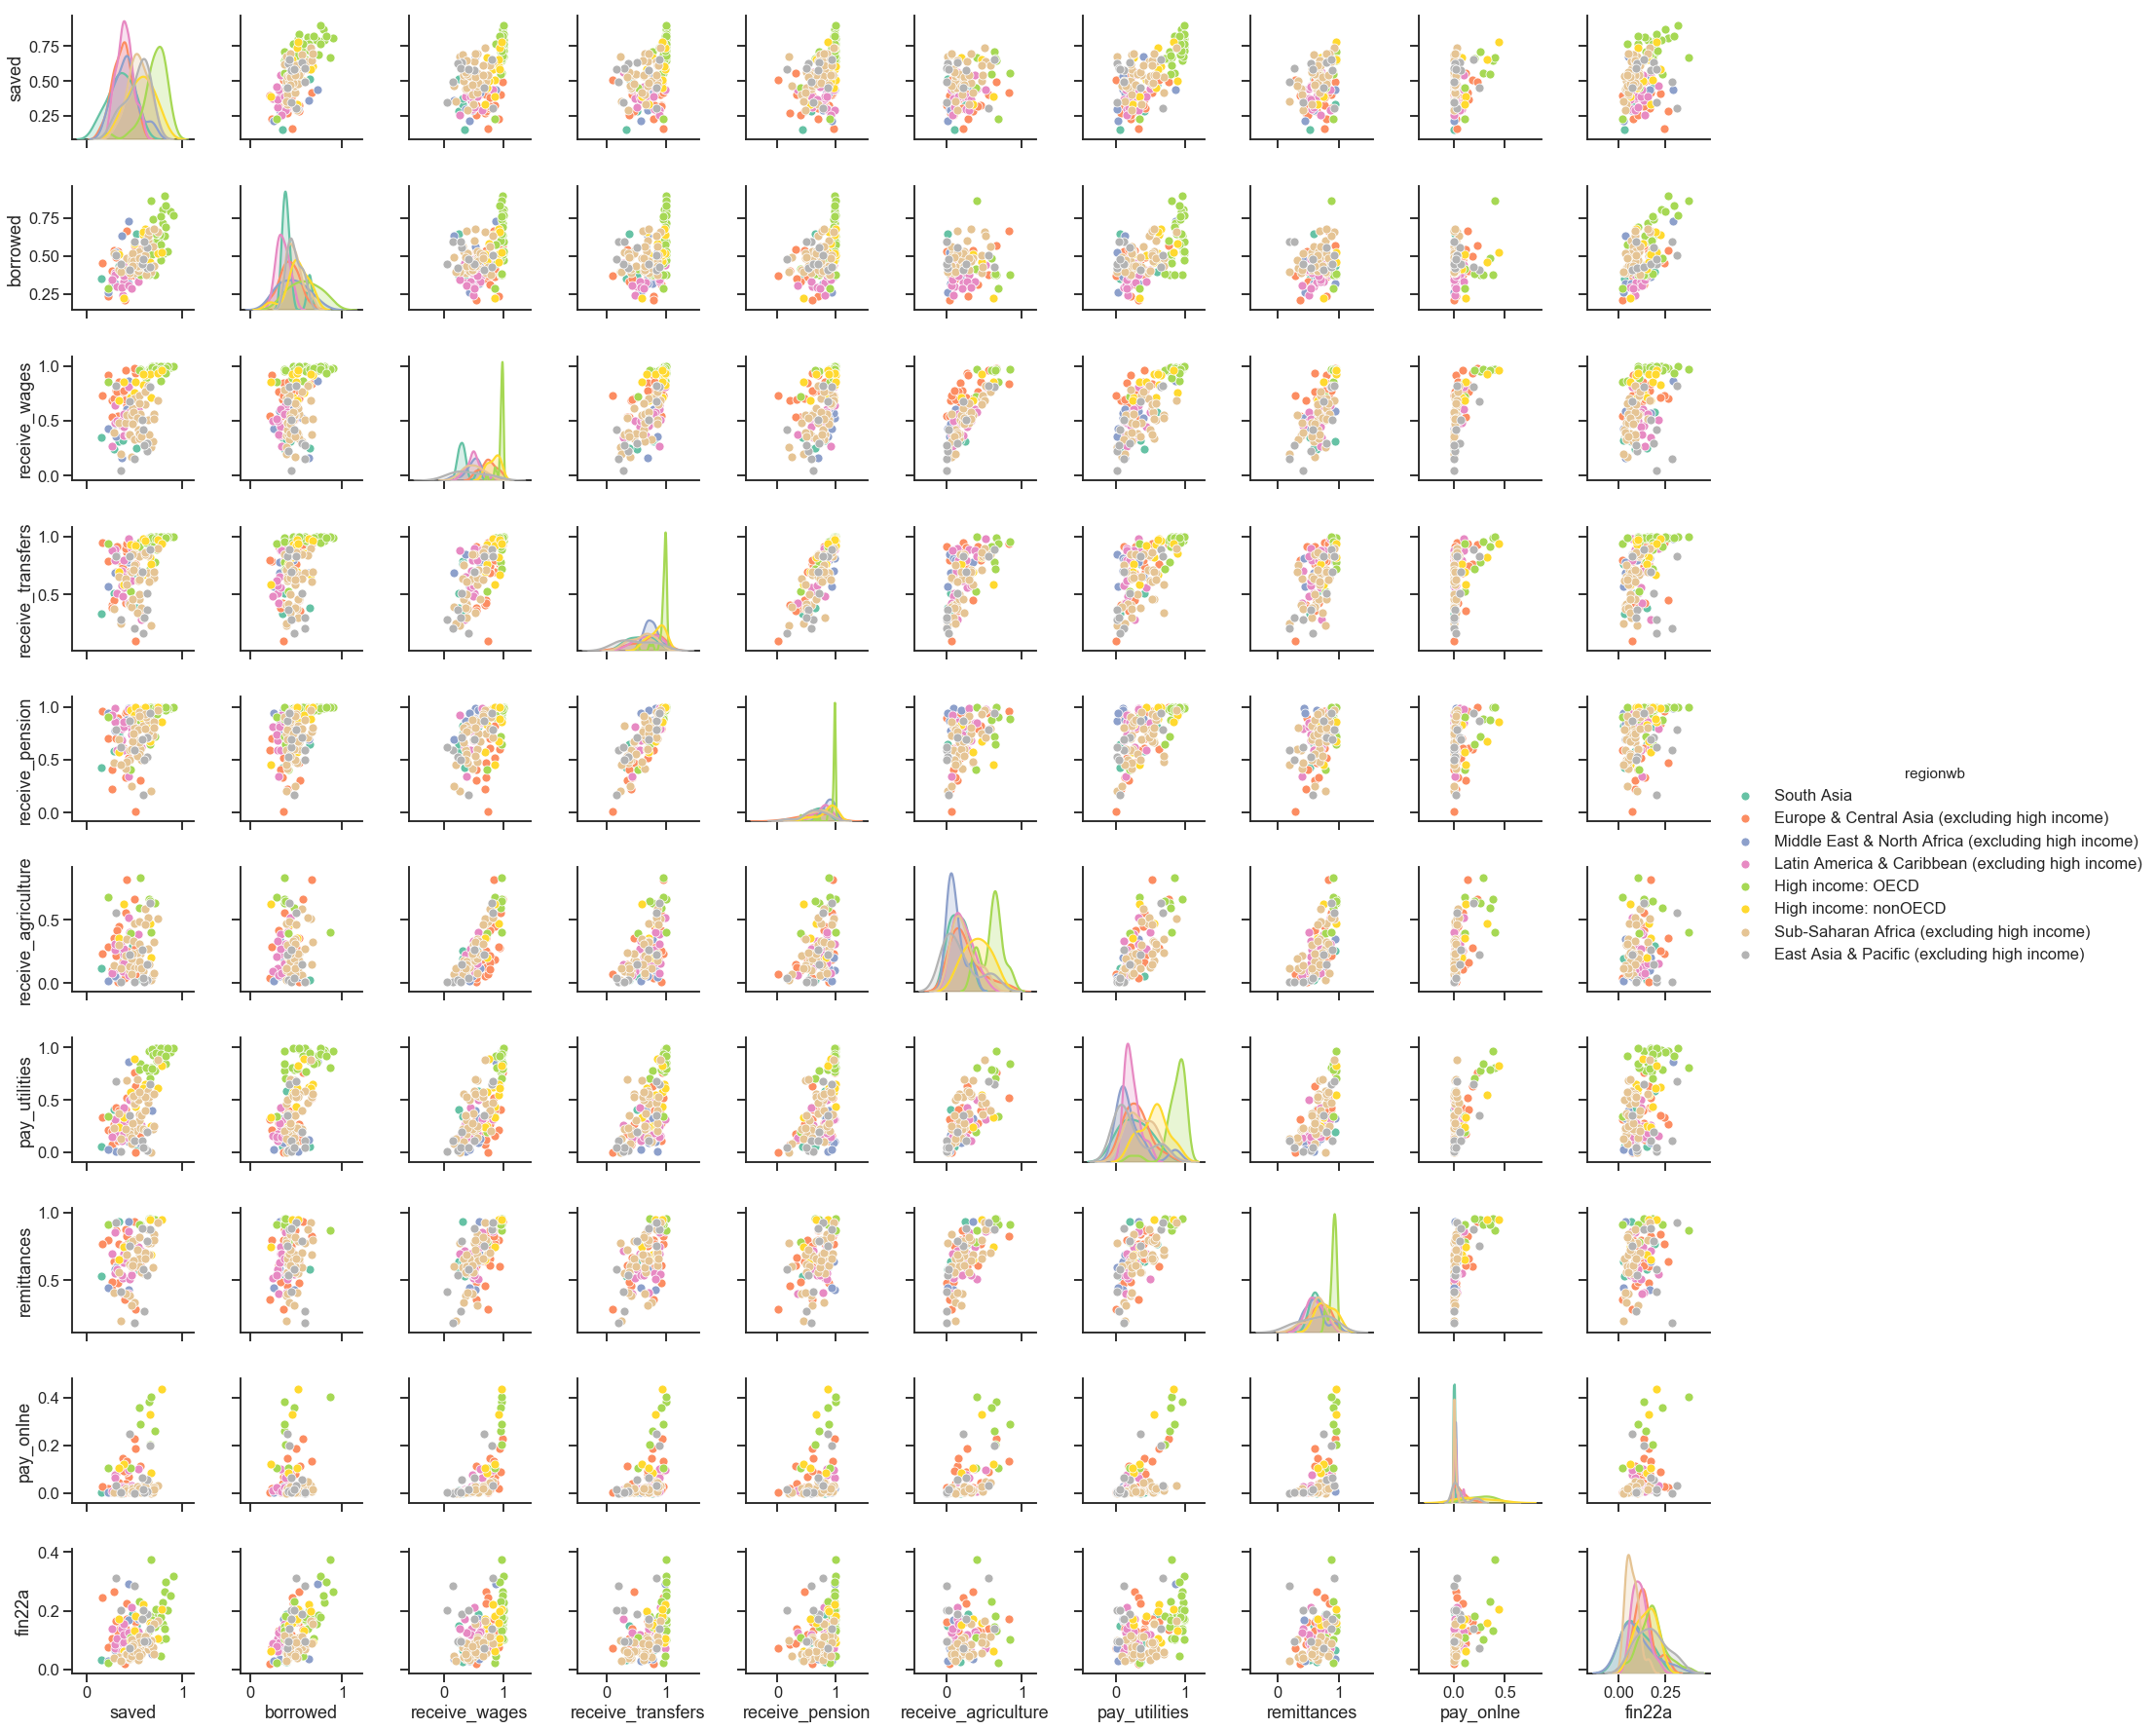

In [23]:
#Graficamos la relación entre indicadores
plt.figure(figsize=(12,8))
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.pairplot(data=gfi_p2.iloc[:,0:1].join(gfi_p2.iloc[:,-10:-1]).join(gfi_p2[['fin22a']]), hue='regionwb', palette='Set2')
plt.show()

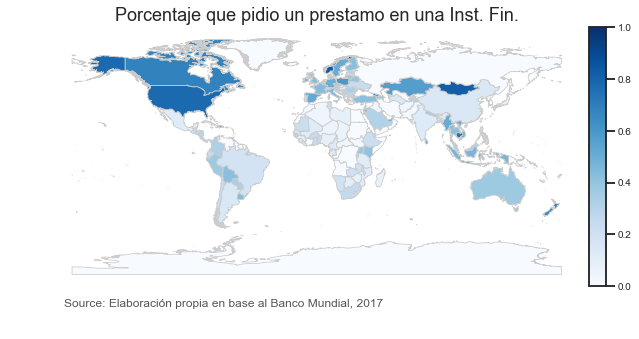

In [24]:
mapa_cuenta = mapamundi.set_index('COUNTRY').join(gfi_p2)

vmin, vmax = 0, 1
fig, ax = plt.subplots(1, figsize=(10, 6))

mapa_cuenta.plot(column='fin22a', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.title("Porcentaje que pidio un prestamo en una Inst. Fin.")
plt.axis('off')
plt.annotate('Source: Elaboración propia en base al Banco Mundial, 2017',xy=(0.1, .12),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10) 
plt.show()
#fig.savefig(“mapa_cuenta.png”, dpi=300)

In [25]:
#Incluimos el credito bancario sobre el PBI desde la API del Banco Mundial para comparar
cred_pbi=wbdata.get_dataframe({'GFDD.DI.14': 'values'}, country=(paises_c.tolist()), data_date=datetime.datetime(2016,1,1), convert_date=False, keep_levels=True)
cred_pbi=(pd.pivot_table(cred_pbi, index='country', columns=['date'], values=['values']))
cred_pbi.columns=['cred_pbi']
gfi_p3=gfi_p2.join(cred_pbi)


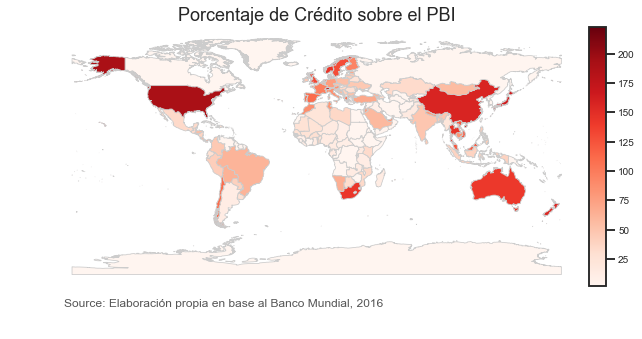

In [26]:
mapa_cred = mapamundi.set_index('COUNTRY').join(cred_pbi)

vmin, vmax = cred_pbi.min(), cred_pbi.max()
fig, ax = plt.subplots(1, figsize=(10, 6))

mapa_cred.plot(column='cred_pbi', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.title("Porcentaje de Crédito sobre el PBI")
plt.axis('off')
plt.annotate('Source: Elaboración propia en base al Banco Mundial, 2016',xy=(0.1, .12),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10) 
plt.show()